## Summarising data across repeated runs of same workload 

In [1]:
import json
import pickle
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# GLOBAL VARIABLES / PARAMETERS
WORKLOAD = "WITH_ISTIO_WITH_WORKLOAD"
TRACE_LOGS = f"{WORKLOAD}/"
PARSED_OUTPUTS = f"parsedOutputs/{WORKLOAD}"
NUM_RUNS = 3
FUNC_BLACKLIST = {"BLANK", "do_syscall_64()"}

#### Identifying most important functions by count

In [3]:

def get_runs():
    runs = []
    for run_data in os.listdir(PARSED_OUTPUTS):
        with open(os.path.join(PARSED_OUTPUTS, run_data), "r") as fd:
            data = json.load(fd)
            runs.append(data)
    return runs


Sample JSON
```json
"2016654": [
    {
      "function_name": "do_syscall_64() ",
      "time": 100134.8,
      "children": [
        {
          "function_name": "__x64_sys_epoll_wait() ",
          "time": 100129.9,
          "children": [
            {
              "function_name": "do_epoll_wait() ",
              "time": 100129.6,
              "children": [
                {
                  "function_name": "__fdget() ",
                  "time": 0.862,
                  "children": [
                    {
                      "function_name": "__fget_light();",
                      "time": 0.561,
                      "children": []
                    }
                  ]
                }
```

In [4]:
def get_function_counts(run, recurse=False):
    count = {}

    def get_counts(function, count, recurse):
        func_name = function["function_name"].strip().strip(";")
        if func_name not in FUNC_BLACKLIST:
            count[func_name] = count.get(func_name, 0) + 1
        if recurse:
            for child in function["children"]:
                get_counts(child, count, recurse)
    for pid in run:
        for function in run[pid]:
            get_counts(function, count, recurse)
        
    return count

def plot_counts(count, title=WORKLOAD, maxnum=20):
    maxnum = min(maxnum, len(count))
    x = sorted(list(count.keys()), key=lambda x: count[x], reverse=True)[ :maxnum]
    y = [count[_] for _ in x]


    plt.figure(figsize=(10, 4))
    plt.xticks(np.arange(len(x)), x, rotation=90)
    plt.title(title)
    plt.bar(x, y)
    plt.show()
    del x, y

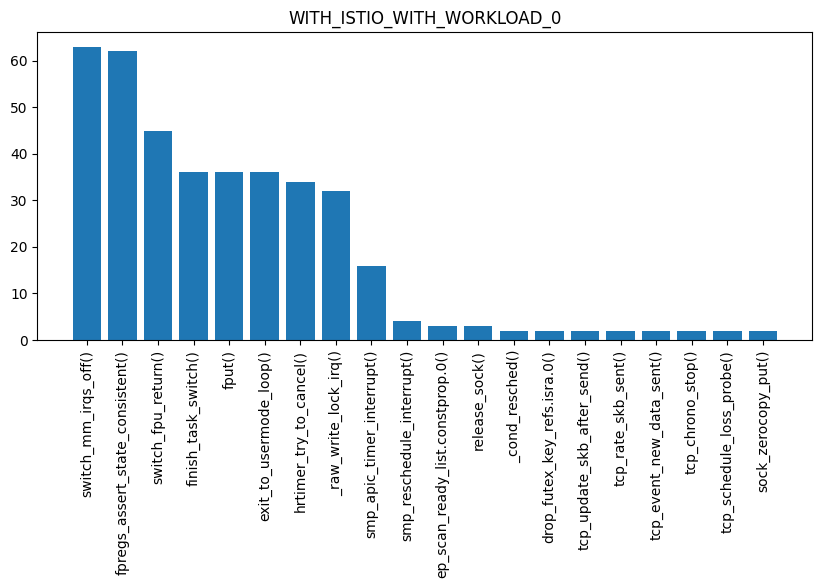

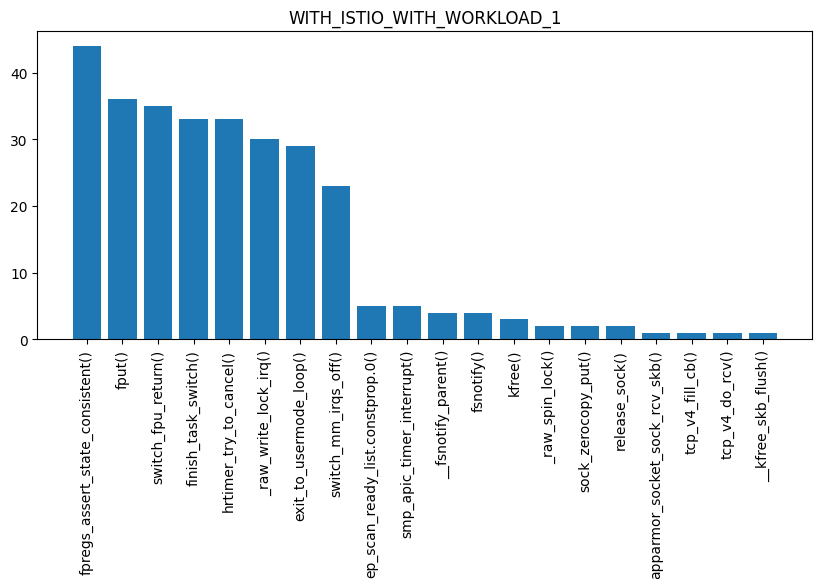

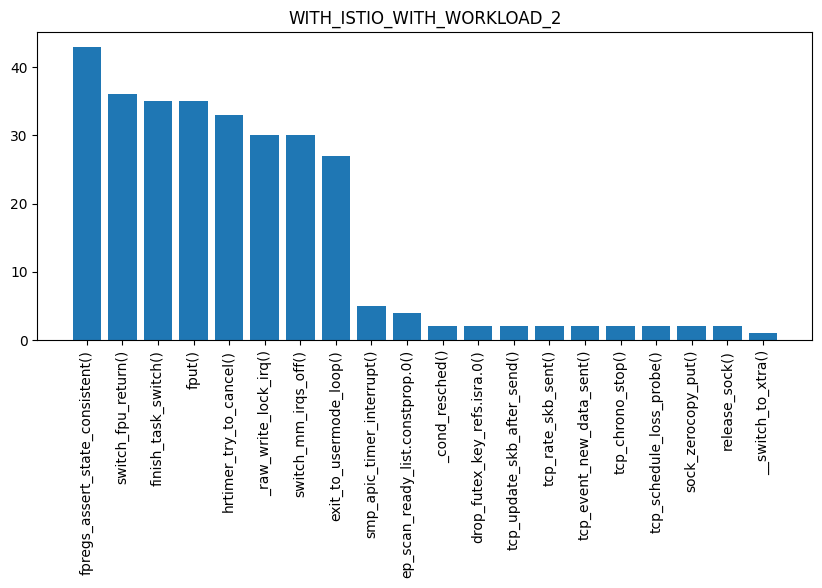

In [5]:
runs = get_runs()
for i in range(NUM_RUNS):
    count = get_function_counts(runs[i])
    plot_counts(count, title=f"{WORKLOAD}_{i}")

Points of Note
* switch_mm_irqs_off() is the most called function call consistenctly
* The function call counts are identical across the runs
* There are a total of only around 10-13 functions called in the idle runs at the top level of the callgraph

#### Parsing the callgraph recursively

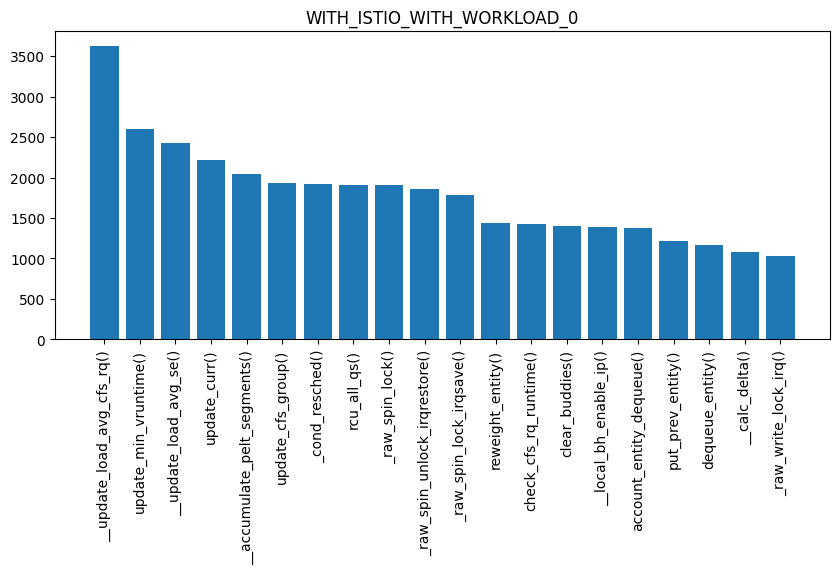

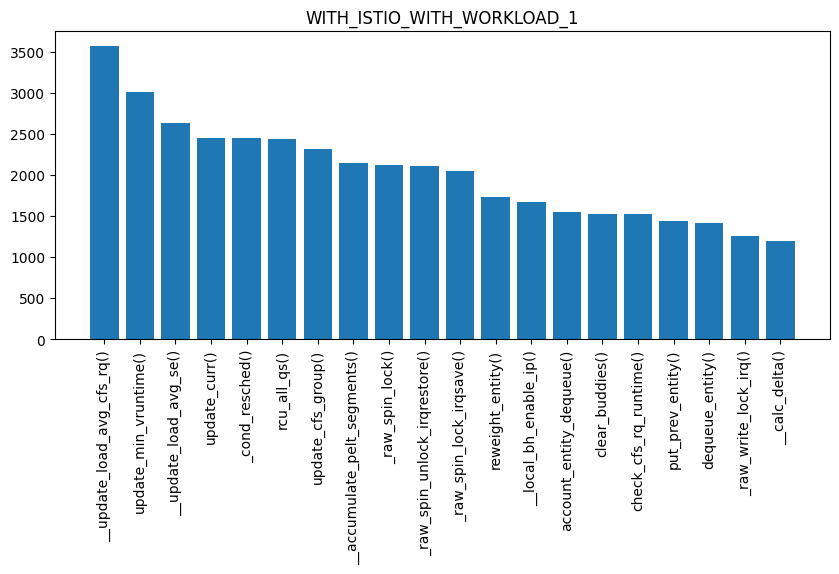

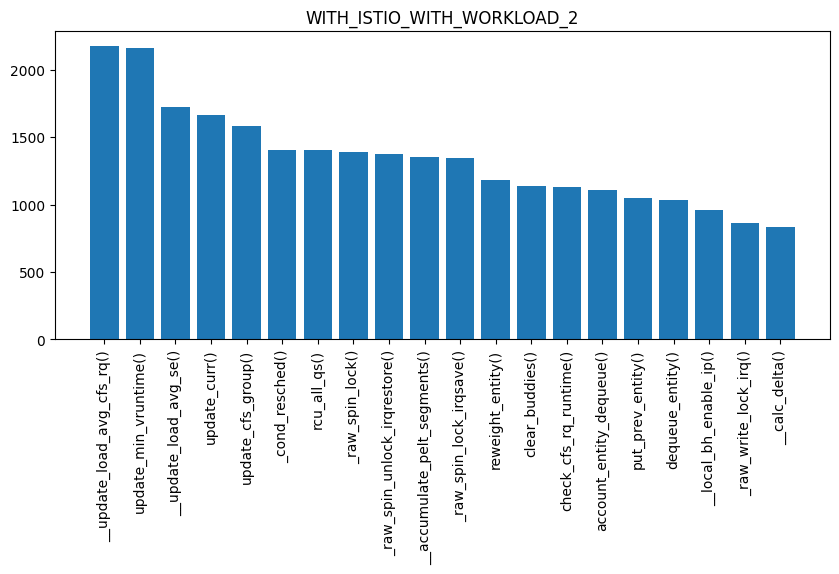

In [6]:
for i in range(NUM_RUNS):
    count = get_function_counts(runs[i], recurse=True)
    plot_counts(count, title=f"{WORKLOAD}_{i}")

In [7]:
function_counts = [get_function_counts(run, recurse=True) for run in runs]

with open(f"pickles/function_counts/{WORKLOAD}.pickle", "wb") as f:
    pickle.dump(function_counts, file=f)

In [8]:
print(len(function_counts[0]), len(function_counts[1]), len(function_counts[2]))

811 1118 754


In [9]:
for i in range(NUM_RUNS):
    for j in range(NUM_RUNS):
        if i == j:
            continue

        print(f"Calls in {i} but not in {j} ", 
            set(function_counts[i].keys()).difference(set(function_counts[j].keys())), sep="\n", end="\n")
        print()

Calls in 0 but not in 1 
{'put_task_struct_rcu_user()', 'prep_new_page()', 'policy_node()', 'find_vma()', 'mem_cgroup_charge_statistics()', 'kthread_blkcg()', '__memcg_kmem_uncharge()', 'skb_try_coalesce()', 'propagate_protected_usage()', 'unfreeze_partials.isra.0()', 'mod_zone_page_state()', 'flush_tlb_func_remote()', 'do_anonymous_page()', 'tcp_try_coalesce()', 'task_dead_fair()', 'tcp_write_timer_handler()', '__sk_mem_reclaim()', 'should_fail_alloc_page()', 'mem_cgroup_try_charge_delay()', 'mem_cgroup_from_task()', 'tcp_write_timer()', 'scheduler_ipi()', '__alloc_pages_nodemask()', 'flush_smp_call_function_queue()', 'epi_rcu_free()', '__x64_sys_epoll_pwait()', '__inc_numa_state()', 'rcu_gp_kthread_wake()', 'try_charge()', 'kprobe_flush_task()', 'vmacache_find()', '__lru_cache_add()', 'put_task_stack()', 'page_counter_uncharge()', 'mem_cgroup_commit_charge()', 'smp_reschedule_interrupt()', 'policy_nodemask()', '__memcg_kmem_uncharge_memcg()', 'do_async_page_fault()', 'refill_stock()'

In [10]:
def get_count_diff(function_counts):
    count_diff = {}
    for i in range(NUM_RUNS):
        for j in range(NUM_RUNS):
            if i==j:
                continue
            count_diff[f"{i}-{j}"]= {}
            for function in function_counts[i].keys():
                lhs = function_counts[i].get(function, 0) 
                rhs = function_counts[j].get(function, 0)
                if lhs <= rhs: 
                    continue
                count_diff[f"{i}-{j}"][function] = (lhs - rhs) / lhs * 100
    return count_diff


In [11]:
diff_count = get_count_diff(function_counts=function_counts)

In [12]:
[(x, diff_count["0-1"][x]) for x in sorted(diff_count["0-1"], key=lambda x: diff_count["0-1"][x], reverse=True)]

[('do_async_page_fault()', 100.0),
 ('do_page_fault()', 100.0),
 ('__do_page_fault()', 100.0),
 ('down_read_trylock()', 100.0),
 ('find_vma()', 100.0),
 ('vmacache_find()', 100.0),
 ('handle_mm_fault()', 100.0),
 ('mem_cgroup_from_task()', 100.0),
 ('__count_memcg_events()', 100.0),
 ('__handle_mm_fault()', 100.0),
 ('pmd_devmap_trans_unstable()', 100.0),
 ('do_anonymous_page()', 100.0),
 ('alloc_pages_vma()', 100.0),
 ('__get_vma_policy()', 100.0),
 ('get_vma_policy.part.0()', 100.0),
 ('get_task_policy.part.0()', 100.0),
 ('policy_nodemask()', 100.0),
 ('policy_node()', 100.0),
 ('__alloc_pages_nodemask()', 100.0),
 ('should_fail_alloc_page()', 100.0),
 ('__next_zones_zonelist()', 100.0),
 ('get_page_from_freelist()', 100.0),
 ('__inc_numa_state()', 100.0),
 ('prep_new_page()', 100.0),
 ('mem_cgroup_try_charge_delay()', 100.0),
 ('mem_cgroup_try_charge()', 100.0),
 ('get_mem_cgroup_from_mm()', 100.0),
 ('try_charge()', 100.0),
 ('page_counter_try_charge()', 100.0),
 ('propagate_prote

In [13]:
[(x, diff_count["0-2"][x]) for x in sorted(diff_count["0-2"], key=lambda x: diff_count["0-2"][x], reverse=True)]

[('rcu_report_qs_rnp()', 100.0),
 ('do_async_page_fault()', 100.0),
 ('do_page_fault()', 100.0),
 ('__do_page_fault()', 100.0),
 ('down_read_trylock()', 100.0),
 ('find_vma()', 100.0),
 ('vmacache_find()', 100.0),
 ('handle_mm_fault()', 100.0),
 ('mem_cgroup_from_task()', 100.0),
 ('__count_memcg_events()', 100.0),
 ('__handle_mm_fault()', 100.0),
 ('pmd_devmap_trans_unstable()', 100.0),
 ('do_anonymous_page()', 100.0),
 ('alloc_pages_vma()', 100.0),
 ('__get_vma_policy()', 100.0),
 ('get_vma_policy.part.0()', 100.0),
 ('get_task_policy.part.0()', 100.0),
 ('policy_nodemask()', 100.0),
 ('policy_node()', 100.0),
 ('__alloc_pages_nodemask()', 100.0),
 ('should_fail_alloc_page()', 100.0),
 ('__next_zones_zonelist()', 100.0),
 ('get_page_from_freelist()', 100.0),
 ('__inc_numa_state()', 100.0),
 ('prep_new_page()', 100.0),
 ('kernel_poison_pages()', 100.0),
 ('page_poisoning_enabled()', 100.0),
 ('mem_cgroup_try_charge_delay()', 100.0),
 ('mem_cgroup_try_charge()', 100.0),
 ('get_mem_cgro

In [14]:
[(x, diff_count["1-0"][x]) for x in sorted(diff_count["1-0"], key=lambda x: diff_count["1-0"][x], reverse=True)]

[('hrtimer_force_reprogram()', 100.0),
 ('eventfd_poll()', 100.0),
 ('eventfd_read()', 100.0),
 ('sched_cfs_period_timer()', 100.0),
 ('__put_page()', 100.0),
 ('__put_compound_page()', 100.0),
 ('PageHuge()', 100.0),
 ('__page_cache_release()', 100.0),
 ('free_compound_page()', 100.0),
 ('mem_cgroup_uncharge()', 100.0),
 ('__free_pages_ok()', 100.0),
 ('free_one_page()', 100.0),
 ('__mod_zone_page_state()', 100.0),
 ('__x64_sys_socket()', 100.0),
 ('__sys_socket()', 100.0),
 ('__sock_create()', 100.0),
 ('security_socket_create()', 100.0),
 ('apparmor_socket_create()', 100.0),
 ('aa_af_perm()', 100.0),
 ('netlink_create()', 100.0),
 ('__netlink_create()', 100.0),
 ('sk_alloc()', 100.0),
 ('sk_prot_alloc()', 100.0),
 ('__kmalloc()', 100.0),
 ('security_sk_alloc()', 100.0),
 ('mem_cgroup_sk_alloc()', 100.0),
 ('cgroup_sk_alloc()', 100.0),
 ('sock_init_data()', 100.0),
 ('init_timer_key()', 100.0),
 ('sock_prot_inuse_add()', 100.0),
 ('security_socket_post_create()', 100.0),
 ('apparmor_

In [15]:
[(x, diff_count["2-0"][x]) for x in sorted(diff_count["2-0"], key=lambda x: diff_count["2-0"][x], reverse=True)]

[('_nohz_idle_balance()', 100.0),
 ('syscall_trace_enter()', 100.0),
 ('__secure_computing()', 100.0),
 ('__seccomp_filter()', 100.0),
 ('hrtimer_force_reprogram()', 100.0),
 ('eventfd_poll()', 100.0),
 ('eventfd_read()', 100.0),
 ('cursor_timer_handler()', 100.0),
 ('queue_work_on()', 100.0),
 ('inet6_recvmsg()', 100.0),
 ('inet6_sendmsg()', 100.0),
 ('nf_ct_gc_expired [nf_conntrack]()', 100.0),
 ('nf_ct_delete [nf_conntrack]()', 100.0),
 ('nf_conntrack_eventmask_report [nf_conntrack]()', 100.0),
 ('ctnetlink_conntrack_event [nf_conntrack_netlink]()', 100.0),
 ('nfnetlink_has_listeners [nfnetlink]()', 100.0),
 ('netlink_has_listeners()', 100.0),
 ('nf_ct_delete_from_lists [nf_conntrack]()', 100.0),
 ('nf_ct_helper_destroy [nf_conntrack]()', 100.0),
 ('nf_conntrack_double_lock.isra.0 [nf_conntrack]()', 100.0),
 ('nf_conntrack_lock [nf_conntrack]()', 100.0),
 ('nf_ct_remove_expectations [nf_conntrack]()', 100.0),
 ('nf_conntrack_double_unlock [nf_conntrack]()', 100.0),
 ('nf_ct_add_to_d

In [16]:
[(x, diff_count["2-1"][x]) for x in sorted(diff_count["2-1"], key=lambda x: diff_count["2-1"][x], reverse=True)]

[('_nohz_idle_balance()', 100.0),
 ('syscall_trace_enter()', 100.0),
 ('__secure_computing()', 100.0),
 ('__seccomp_filter()', 100.0),
 ('__x64_sys_epoll_pwait()', 100.0),
 ('set_user_sigmask()', 100.0),
 ('epi_rcu_free()', 100.0),
 ('smp_reschedule_interrupt()', 100.0),
 ('scheduler_ipi()', 100.0),
 ('cursor_timer_handler()', 100.0),
 ('queue_work_on()', 100.0),
 ('futex_wait()', 75.0),
 ('futex_wait_setup()', 75.0),
 ('get_futex_value_locked()', 75.0),
 ('futex_wait_queue_me()', 75.0),
 ('__switch_to_xtra()', 71.42857142857143),
 ('i_callback()', 66.66666666666666),
 ('sock_free_inode()', 66.66666666666666),
 ('update_group_capacity()', 50.0),
 ('tick_do_update_jiffies64.part.0()', 50.0),
 ('do_timer()', 50.0),
 ('calc_global_load()', 50.0),
 ('update_wall_time()', 50.0),
 ('timekeeping_advance()', 50.0),
 ('ntp_tick_length()', 50.0),
 ('timekeeping_update()', 50.0),
 ('ntp_get_next_leap()', 50.0),
 ('update_vsyscall()', 50.0),
 ('raw_notifier_call_chain()', 50.0),
 ('update_fast_tim

In [17]:
[(x, diff_count["1-2"][x]) for x in sorted(diff_count["1-2"], key=lambda x: diff_count["1-2"][x], reverse=True)]

[('sched_slice.isra.0()', 100.0),
 ('get_partial_node.isra.0.part.0()', 100.0),
 ('rcu_report_qs_rnp()', 100.0),
 ('detach_entity_cfs_rq()', 100.0),
 ('propagate_entity_cfs_rq()', 100.0),
 ('attach_task()', 100.0),
 ('delayed_put_pid()', 100.0),
 ('put_pid.part.0()', 100.0),
 ('put_pid_ns()', 100.0),
 ('delayed_put_task_struct()', 100.0),
 ('__put_task_struct()', 100.0),
 ('cgroup_free()', 100.0),
 ('task_numa_free()', 100.0),
 ('security_task_free()', 100.0),
 ('yama_task_free()', 100.0),
 ('yama_ptracer_del()', 100.0),
 ('apparmor_task_free()', 100.0),
 ('exit_creds()', 100.0),
 ('key_put()', 100.0),
 ('profile_handoff_task()', 100.0),
 ('atomic_notifier_call_chain()', 100.0),
 ('free_task()', 100.0),
 ('put_seccomp_filter()', 100.0),
 ('__put_seccomp_filter()', 100.0),
 ('arch_release_task_struct()', 100.0),
 ('sched_cfs_period_timer()', 100.0),
 ('__put_page()', 100.0),
 ('__put_compound_page()', 100.0),
 ('PageHuge()', 100.0),
 ('__page_cache_release()', 100.0),
 ('free_compound_p

### Conclusion
* There is not a signifiicant difference between the counts of the various calls.
* Especially in without-istio-without-workload, most calls are seen very infrequently 
* The most frequent calls can be noted and assigned low weightage in future anlaysis